# **Customer Segmentation using K Mean Clustering**

Customer Segmentation using K-Means Clustering" is a project focused on grouping customers based on spending score and income. After performing feature engineering to prepare the data, K-Means clustering was used to identify distinct customer segments. The resulting clusters reveal patterns of customer behavior, such as high-income, high-spending groups, and low-income, low-spending groups, helping businesses better understand their customer base for targeted marketing strategies.

In [96]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [97]:
#Loading the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATASETS/marketing_campaign.csv", sep="\t")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [98]:
#rows and column
data.shape

(2240, 29)

### **Data Cleaning and Feature Engineering**

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [100]:
# null value present in Income. Droping all null values
data.dropna(inplace=True)

In [101]:
# creating a feature out of "Dt_Customer" that indicates the number of days a customer
#is registered in the firm's database

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [102]:
#Creating a feature "Customer_For"

days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [103]:
data["Marital_Status"].value_counts()

,count
Marital_Status,
Married,857
Together,573
Single,471
Divorced,232
Widow,76
Alone,3
Absurd,2
YOLO,2


In [104]:
data["Education"].value_counts()

,count
Education,
Graduation,1116
PhD,481
Master,365
2n Cycle,200
Basic,54


In [105]:
#Age of customer today
data["Age"] = 2024-data["Year_Birth"]

In [106]:
#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

In [107]:
#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

In [108]:
#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

In [109]:
#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

<ipython-input-109-b89d60b95e90>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


In [110]:
#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

In [111]:
#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [112]:
#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

In [113]:
#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [114]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,131.000000,2525.000000,3.000000,5.000000,1.000000


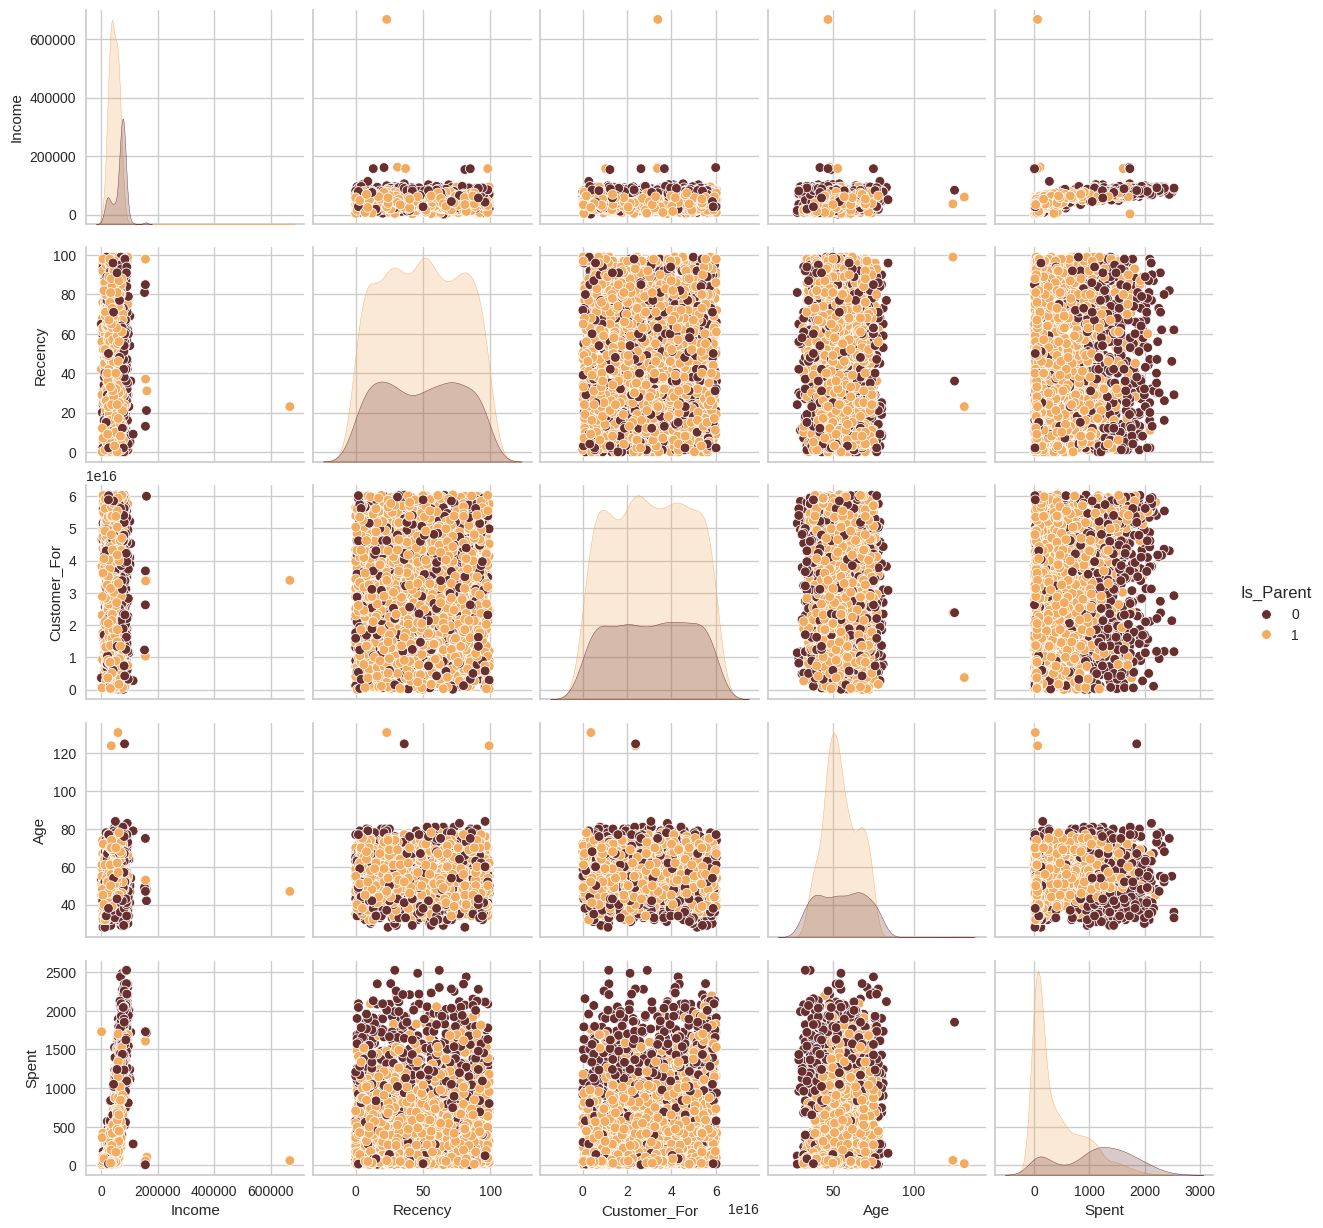

In [115]:
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

In [116]:
#Outliers present in Age and income column. Dropping the outliers by setting a cap on Age and income.

data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]

### **Data Preprocessing**

In [117]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [118]:
#Label Encoding the object dtypes.

LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [119]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

In [120]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


### **Dimentionality Reduction By PCA**

In [121]:
#Initiating PCA to reduce dimentions aka features to 3

pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,5.781993e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,6.424437e-17,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189
col3,2212.0,1.244735e-17,1.231687,-3.625248,-0.853713,-0.050842,0.863974,6.750458


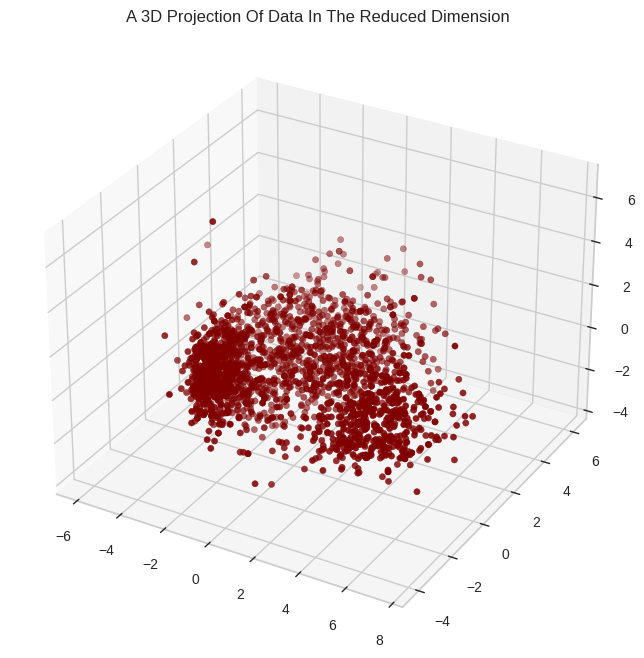

In [122]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

### **Clustering**

Elbow Method to determine the number of clusters to be formed:


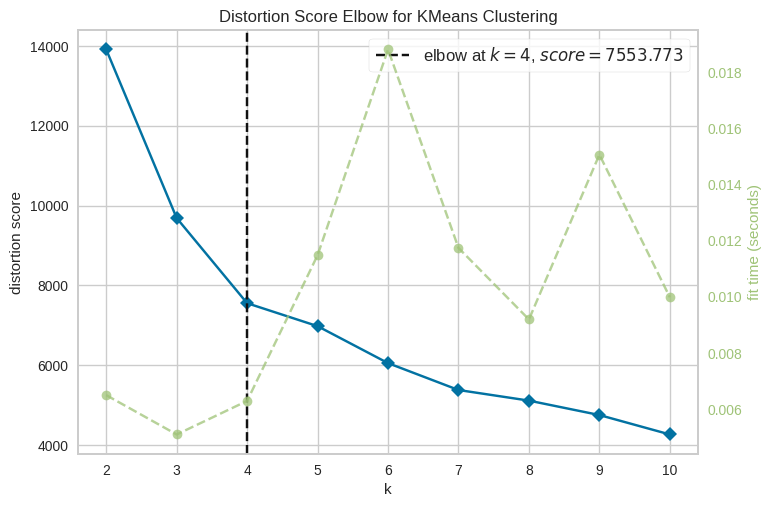

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [123]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

 four will be an optimal number of clusters for this data

In [124]:
#Initiating the KMeans Clustering model
KM = KMeans(n_clusters=4)
# fit model and predict clusters
yhat_KM = KM.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_KM
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_KM

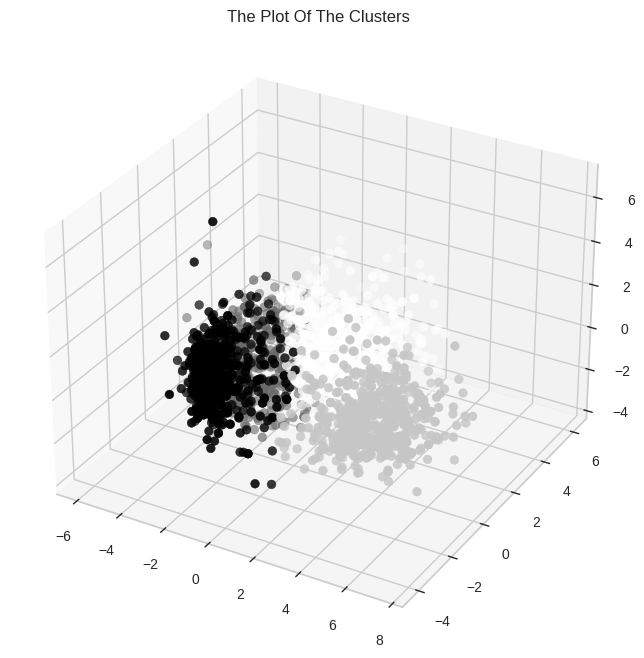

In [125]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o' )
ax.set_title("The Plot Of The Clusters")
plt.show()

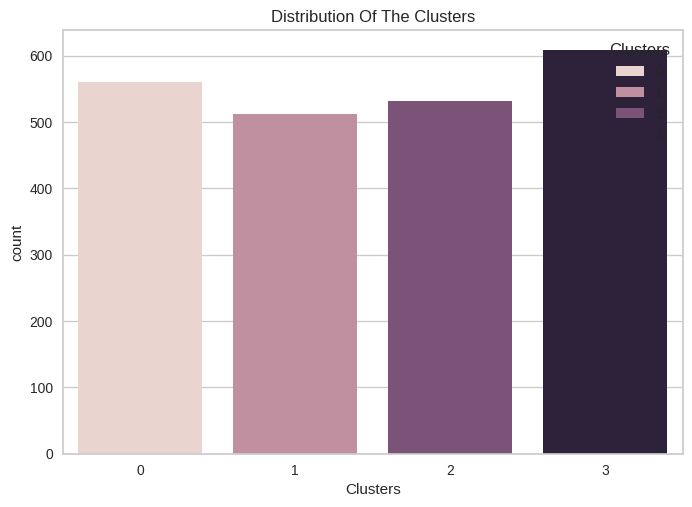

In [126]:
#Plotting countplot of clusters

pl = sns.countplot(x=data["Clusters"],hue=data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

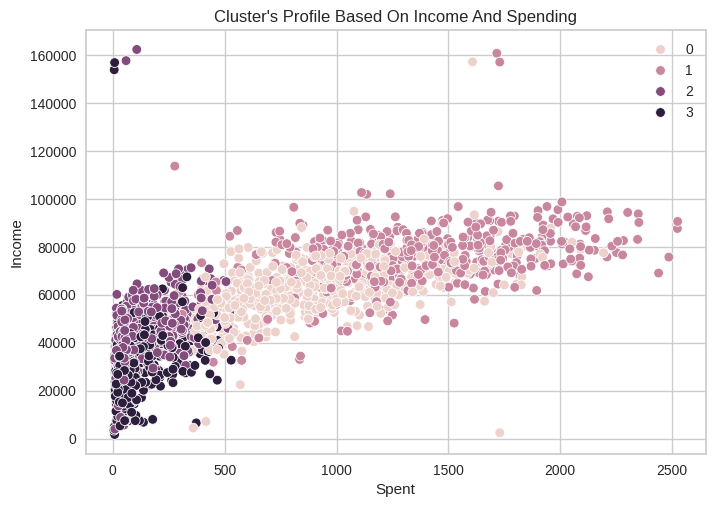

In [127]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs spending plot shows the clusters pattern**

-  Low Income & Low Spending
-  Medium Income & Medium Spending
-  High Income & High Spending
-  Very High Income & Moderate to High Spending